# Uncertainties in Greenland mass loss due to uncertainties in accounting

### Group Project International Summer School in Glaciology, McCarthy, June 7-17 2024

## **How much mass is the Greenland Ice Sheet losing?**

Published numbers vary not only due to the use of different data sets and methods, but also due to use of different ice sheet and basin outlines. Sometimes, glaciers and ice caps disconnected from the main ice sheet are included, sometimes they are not. This makes comparison challenging, and a community consensus is needed. In this project, we will explore different methods for basin delineation.

<img src="gris_basins_tweet.png" alt="Tweet by Hester Jiskoot on the plethora of Greenland basins" style="width: 500px;"/>

## Method 1: Delineation using flowlines

In [32]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp
from shapely.geometry import Point, LineString, shape
import pylab as plt

from glacier_flow_tools.interpolation import velocity
from glacier_flow_tools.pathlines import (
    compute_pathline,
    series_to_pathline_geopandas_dataframe,
    pathline_to_line_geopandas_dataframe,
)
from glacier_flow_tools.utils import register_colormaps
register_colormaps()

In [2]:
CW = gp.read_file('data/kuba-devide/CW.shp')
SW = gp.read_file('data/kuba-devide/SW_boundary.shp')
NW = gp.read_file('data/kuba-devide/NW_Boundary.shp')

Start points for testing:
Point(-208_950, -2_294_747), Point(-210_477, -2_294_869), Point(-212_792, -2_299_682), Point(-216_082, -2_300_840) <- dont work for now
Point(-201_960, -2_200_568), Point(-200_223, -2_202_620)
Point(-198_960, -2_200_989), Point(-200_549, -2_199_410)
Point(-188_000, -2_255_000), Point(-182_000, -2_290_000) <- Jakobshavn
x -2_180_000, -2_175_000
y -2_180_000, -2_175_000
Point(-201_226, -2_249_818), Point(-208_295, -2_250_154)

Glaciers for testing

Sermeq Kujalleq (Store Glacier): Point(-206_410, -2_131_166), Point(-204_720, -2_134_735)
Sermeq Kujalleq (Store Glacier) (inland): Point(-206_410, -2_131_166), Point(-204_720, -2_134_735)
Sermeq Avannarleq: Point(-203_029, -2_170_415), Point(-198_585, -2_170_854)
Sermeq Kujalleq: Point(-195_787, -2_178_044), Point(-195_955, -2_182_912)
Kangilernata Sermia: Point(-204_906, -2_187_504), Point(-202_368, -2_189362)
Eqip Sermia: Point(-200_634, -2_199_949), Point(-199_582, -2_201_002)
Sermeq Avannarleq: Point(-209_541, -2_249_128), Point(-208_250, -2_249_698)
Jakobshavn Isbrae (Sermeq Kujalleq): Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)
Alanngorliup Sermia: Point(-207_707, -2_297_501), Point(-210_029, -2_298_538)
Saqqarliup Sermia: Point(-212_792, -2_299_682), Point(-216_082, -2_300_840)

In [53]:
hmin = 0.1
hmax = 10.0
tol = 1
start_time = 0
end_time = 100_000
starting_points = [ Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)
]

ds = xr.open_dataset("data/GRE_G0240_0000.nc")
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())

# Reverse for backward pathlines
Vx = -Vx
Vy = -Vy

x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

geom = starting_points
starting_points_df = gp.GeoDataFrame(geometry=geom, crs="EPSG:3413")

pathlines = []
for _, df in starting_points_df.iterrows():
    pathline = compute_pathline(
        [*df.geometry.coords[0]],
        velocity,
        f_args=(Vx, Vy, x, y),
        hmin=hmin,
        hmax=hmax,
        tol=tol,
        start_time=start_time,
        end_time=end_time,
        notebook=True,
        progress=True,
    )
    pathlines.append(pathline)


Integrating pathline:   0%|          | 0/100000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/100000 [00:00<?, ?it/s]

In [54]:
# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)


In [55]:
result

,geometry,vx,vy,v,pathline_id,distance,distance_from_origin,time,error
0,POINT (-188000.000 -2255000.000),44.398132,117.804972,125.893628,0,0.000000,0.000000,0.0,0.000000e+00
1,POINT (-187574.821 -2253901.619),40.759082,115.876486,122.835918,0,1177.802227,1177.802227,10.0,6.652944e-02
2,POINT (-187079.469 -2252695.180),63.775951,116.397236,132.724107,0,1304.173224,2481.975451,20.0,2.208981e-03
3,POINT (-186357.225 -2251574.985),76.644882,110.829553,134.750242,0,1332.844032,3814.819483,30.0,2.992333e-02
4,POINT (-185456.726 -2250461.353),96.422865,106.394910,143.587066,0,1432.157265,5246.976748,40.0,3.709970e-02
...,...,...,...,...,...,...,...,...,...
19997,POINT (287003.503 -2272033.792),-0.003639,0.004132,0.005505,1,0.055097,537438.411601,99960.0,1.048797e-14
19998,POINT (287003.467 -2272033.751),-0.003633,0.004125,0.005497,1,0.055012,537438.466613,99970.0,1.086623e-14
19999,POINT (287003.430 -2272033.710),-0.003628,0.004118,0.005489,1,0.054928,537438.521541,99980.0,9.387117e-15
20000,POINT (287003.394 -2272033.669),-0.003623,0.004112,0.005480,1,0.054843,537438.576383,99990.0,5.709156e-15


In [56]:
# Now results are lines
result = pd.concat(
        [
            pathline_to_line_geopandas_dataframe(pathlines[k][0], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)
result.to_file('2lines.shp', mode="w")

/var/folders/nd/kkcv2d591j11jk2h39wv8_zr0000gr/T/ipykernel_10149/827185828.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result.to_file('2lines.shp', mode="w")


<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

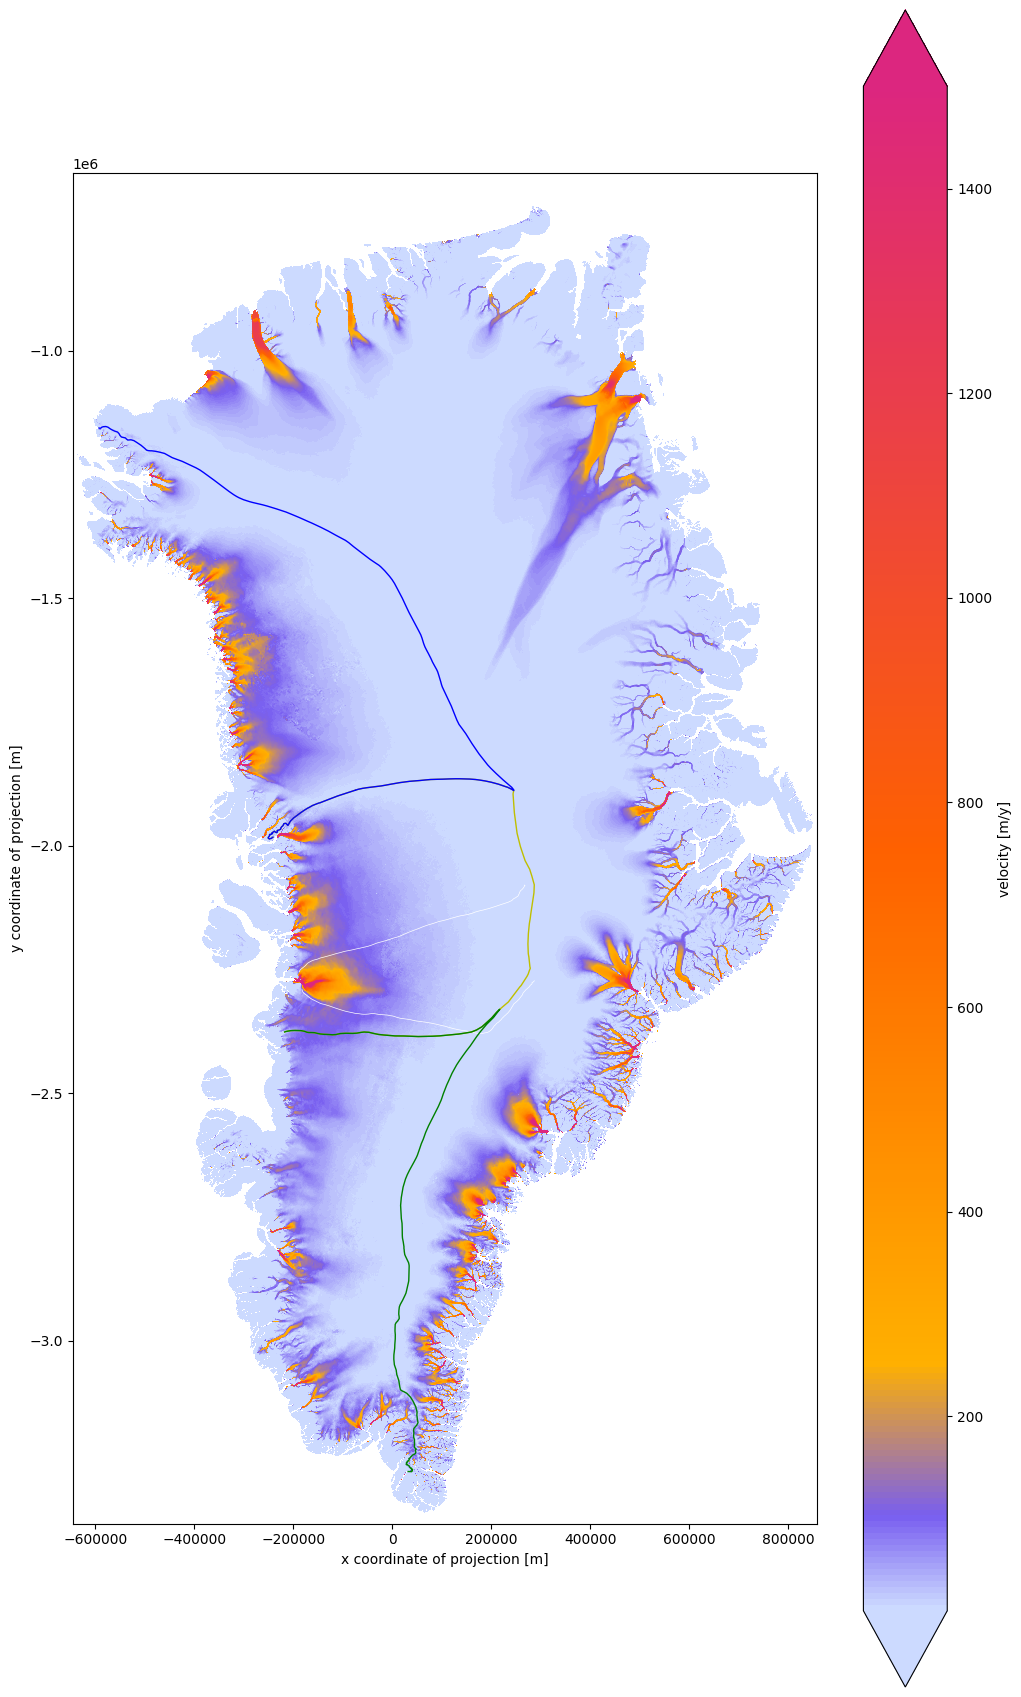

In [57]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
result.plot(markersize=25,
            color="w",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=0.5,
)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

In [27]:
#result.to_file(line_p, mode="w")

In [36]:
term_line.type

/var/folders/nd/kkcv2d591j11jk2h39wv8_zr0000gr/T/ipykernel_10149/3528941515.py:1: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  term_line.type


'LineString'

<Axes: >

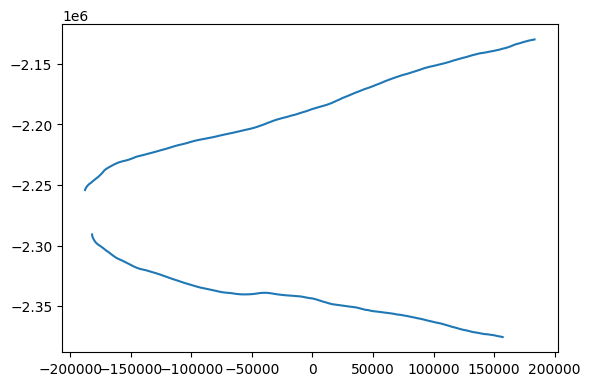

In [28]:
result.plot()

In [29]:
regions = ["NW", "NE", "NO", "SE", "SW", "CW"]
imbie_regions = {}
for r in regions:
    imbie_regions[r] = imbie[imbie["SUBREGION1"] == r].reset_index()
line = imbie_regions["CW"].intersection(imbie_regions["SE”])
line.line_merge(directed=True)

SyntaxError: unterminated string literal (detected at line 5) (1963940419.py, line 5)

<Axes: >

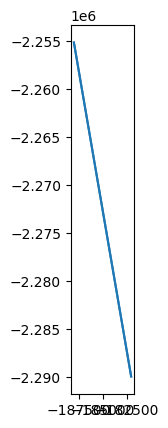

In [40]:
# Connect the terminus dots with a straight line, for now, testing the area calculation. 
term_line = LineString([Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)])
term_line = pd.concat(
        [
            pathline_to_line_geopandas_dataframe([Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)

In [45]:
result_3 = result.geometry.append(term_line.geometry)

AttributeError: 'super' object has no attribute 'append'

## Tasks

- Visualize different drainage basins
- Calculate pathlines and find a way to close them, making a polygon
- Explore role of uncertainties in ITS_LIVE
- Smooth DEM and use Drainage basin calculator

In [97]:
CW

,id,geometry,coords
0,1,"LINESTRING (-218242.252 -2376900.638, -218031....","[[-2376900.638018128, -218242.2520467133], [-2..."


# 1. box dots
many pathlines

In [47]:
x_coord = list(range(-190_000, -185_000, 1000))
y_coord = list(range(-2_180_000, -2_175_000, 1000))
box_points = []
for i in range(0,len(x_coord)):
    for j in range(0,len(y_coord)):
        box_points += [Point(x_coord[i],y_coord[j])]
box_points

[<POINT (-190000 -2180000)>,
 <POINT (-190000 -2179000)>,
 <POINT (-190000 -2178000)>,
 <POINT (-190000 -2177000)>,
 <POINT (-190000 -2176000)>,
 <POINT (-189000 -2180000)>,
 <POINT (-189000 -2179000)>,
 <POINT (-189000 -2178000)>,
 <POINT (-189000 -2177000)>,
 <POINT (-189000 -2176000)>,
 <POINT (-188000 -2180000)>,
 <POINT (-188000 -2179000)>,
 <POINT (-188000 -2178000)>,
 <POINT (-188000 -2177000)>,
 <POINT (-188000 -2176000)>,
 <POINT (-187000 -2180000)>,
 <POINT (-187000 -2179000)>,
 <POINT (-187000 -2178000)>,
 <POINT (-187000 -2177000)>,
 <POINT (-187000 -2176000)>,
 <POINT (-186000 -2180000)>,
 <POINT (-186000 -2179000)>,
 <POINT (-186000 -2178000)>,
 <POINT (-186000 -2177000)>,
 <POINT (-186000 -2176000)>]

In [57]:
hmin = 0.0001
hmax = 25.0
tol = 1
start_time = 0
end_time = 5_000

ds = xr.open_dataset("data/GRE_G0240_0000.nc")
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())

# Reverse for backward pathlines
Vx = -Vx
Vy = -Vy

x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

geom = box_points
starting_points_df = gp.GeoDataFrame(geometry=geom, crs="EPSG:3413")

pathlines = []
for _, df in starting_points_df.iterrows():
    pathline = compute_pathline(
        [*df.geometry.coords[0]],
        velocity,
        f_args=(Vx, Vy, x, y),
        hmin=hmin,
        hmax=hmax,
        tol=tol,
        start_time=start_time,
        end_time=end_time,
        notebook=True,
        progress=True,
    )
    pathlines.append(pathline)

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

In [58]:
# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)

In [59]:
# Now results are lines
result = pd.concat(
        [
            pathline_to_line_geopandas_dataframe(pathlines[k][0], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)
    #result.to_file(line_p, mode="w")



<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

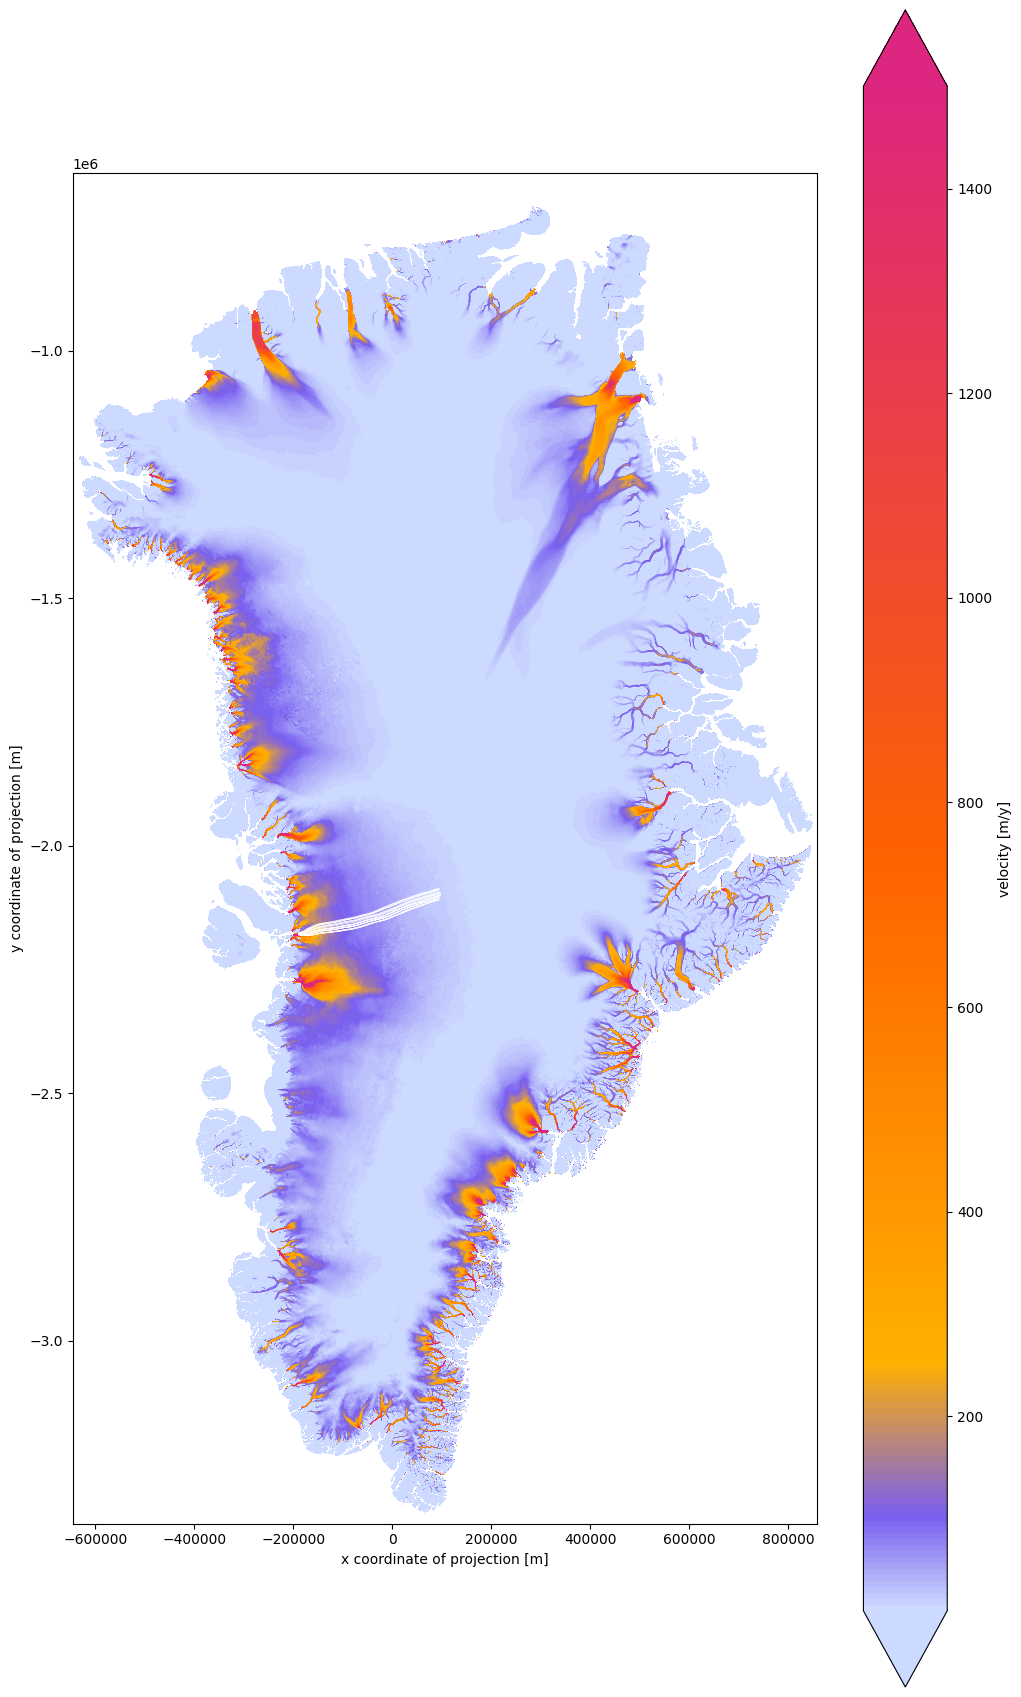

In [60]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
result.plot(markersize=25,
            color="w",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=0.5,
)

# 2. Plotting the devide
we are starting with plotting a devide file defined by other people. 

<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

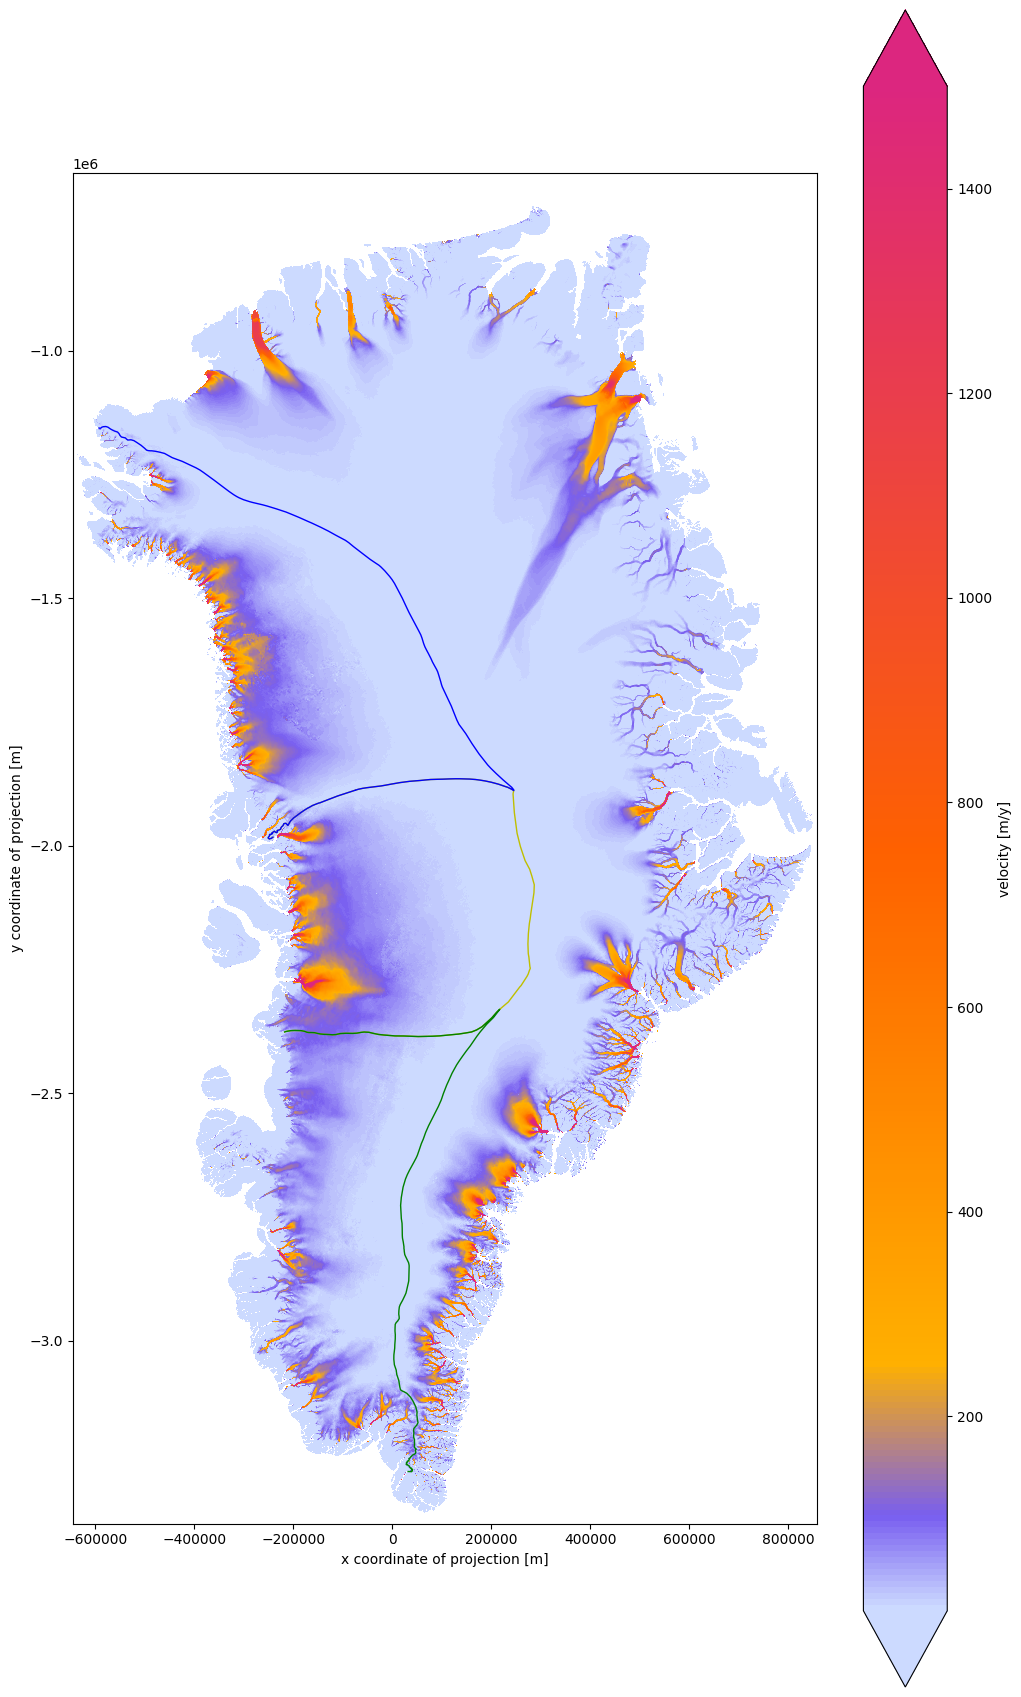

In [88]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

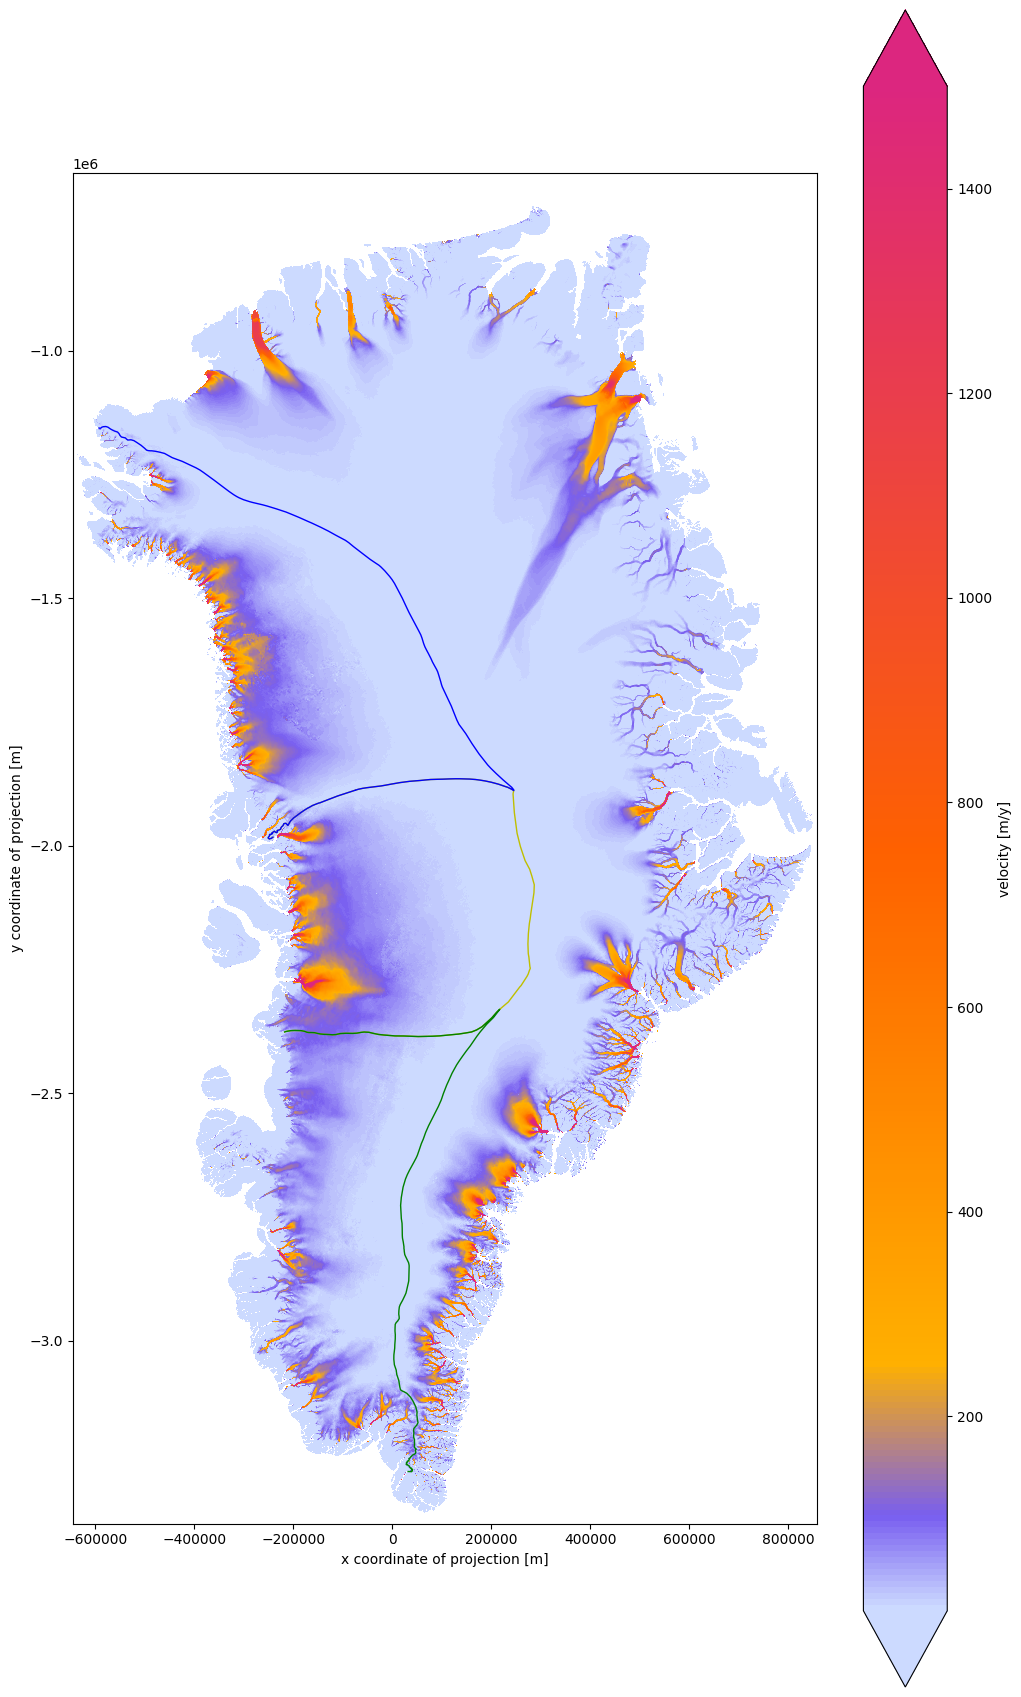

In [88]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

In [ ]:
import geopandas
from shapely import geometry
from shapely.ops import split, snap

gdf = gp.GeoDataFrame([
    {"Feature":'pathway',"ID":1,"geometry": geometry.result},
    {"Feature":'devide',"ID":2, "geometry": geometry.CW}
])

def split_line_by_point(line, point, tolerance: float=1.0e-12):
    return split(snap(line, point, tolerance), point)

result_line = (
    gdf
    .assign(geometry=gdf.apply(
        lambda x: split_line_by_point(
            x.geometry, 
            geometry.Point(x.geometry.coords[1])
        ), axis=1
    ))
    .explode()
    .reset_index(drop=True)
)

import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
import matplotlib.pyplot as plt

df = gp.read_file('PROMICE_GrIS_0_Stereo.shp')

#df = df.loc[df['Field']=='SomeValue']

inras = 'myraster.tif'

src  = rasterio.open(inras)
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords = getFeatures(df)
clipped_array, clipped_transform = mask(dataset=src, shapes=coords, crop=True)

df = df.to_crs(src.crs)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": clipped_array.shape[1],
                 "width": clipped_array.shape[2],
                 "transform": clipped_transform})
out_tif= "clipped_example.tif"
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(clipped_array)
    
clipped = rasterio.open(out_tif)
fig, ax = plt.subplots(figsize=(8, 6))
p1 = df.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(clipped, ax=ax)
ax.axis('off');

In [ ]:
line1 = gp.read_file("data_stuff/Geometries/front.shp")
line2 = gp.read_file("data_stuff/Geometries/line_n.shp")
line3 = gp.read_file("data_stuff/Geometries/line_s.shp")
line4 = gp.read_file("data_stuff/Geometries/to_divide.shp")
s = gp.GeoSeries([line1.geometry[0], line2.geometry[0], line3.geometry[0], line4.geometry[0]])
poly = s.convex_hull
area = poly.area
area
poly.plot()